## Initial imports

In [1]:
from scm.simple_active_learning import SimpleActiveLearningJob
import scm.plams as plams
from scm.external_engines.core import interface_is_installed

assert interface_is_installed(
    "m3gnet"
), "You must first install m3gnet with the AMS package manager"

## Initialize PLAMS

In [2]:
plams.init()

PLAMS working folder: /home/hellstrom/adfhome/scripting/scm/params/examples/ActiveLearning/jupyter_notebooks/example1_molecule_2hydroxyethanal/plams_workdir


## Input system

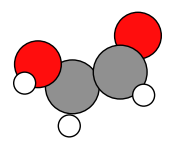

In [3]:
mol = plams.from_smiles("OCC=O")
for at in mol:
    at.properties = {}
plams.plot_molecule(mol)

## Reference engine settings
For time reasons we use the UFF force field as the reference method. Typically you would instead train to DFT using ADF, BAND, or Quantum ESPRESSO.

In [4]:
ref_s = plams.Settings()
ref_s.input.ForceField.Type = "UFF"
ref_s.runscript.nproc = 1

In [5]:
print(plams.AMSJob(settings=ref_s).get_input())

Engine ForceField
  Type UFF
EndEngine




## Molecular dynamics settings
Here, we use the convenient ``AMSNVTJob`` recipe to easily initialize sone MD settings.

In [6]:
md_s = plams.AMSNVTJob(temperature=300, timestep=0.5, nsteps=10000).settings

In [7]:
print(plams.AMSJob(settings=md_s).get_input())

MolecularDynamics
  BinLog
    DipoleMoment False
    PressureTensor False
    Time False
  End
  CalcPressure False
  Checkpoint
    Frequency 1000000
  End
  InitialVelocities
    Temperature 300
    Type Random
  End
  NSteps 10000
  Thermostat
    Tau 200.0
    Temperature 300
    Type NHC
  End
  TimeStep 0.5
  Trajectory
    SamplingFreq 100
    WriteBonds True
    WriteCharges True
    WriteEngineGradients False
    WriteMolecules True
    WriteVelocities True
  End
End

Task MolecularDynamics




## ParAMS ML Training settings

(Technical note: When using ``SimpleActiveLearningJob`` the ParAMS settings go under ``input.ams``. When using ``ParAMSJob`` the settings instead simply go under ``input``. See the ParAMS Python tutorials.)

In [8]:
ml_s = plams.Settings()
ml_s.input.ams.MachineLearning.Backend = "M3GNet"
ml_s.input.ams.MachineLearning.CommitteeSize = 1
ml_s.input.ams.MachineLearning.M3GNet.Model = "UniversalPotential"
ml_s.input.ams.MachineLearning.MaxEpochs = 200
print(SimpleActiveLearningJob(settings=ml_s).get_input())

MachineLearning
  Backend M3GNet
  CommitteeSize 1
  M3GNet
    Model UniversalPotential
  End
  MaxEpochs 200
End



## Active learning settings

In [9]:
al_s = plams.Settings()
al_s.input.ams.ActiveLearning.Steps.Type = "Geometric"
al_s.input.ams.ActiveLearning.Steps.Geometric.Start = 10  # 10 MD frames
al_s.input.ams.ActiveLearning.Steps.Geometric.NumSteps = 5  # 10 AL steps
print(SimpleActiveLearningJob(settings=al_s).get_input())

ActiveLearning
  Steps
    Geometric
      NumSteps 5
      Start 10
    End
    Type Geometric
  End
End



## Simple Active Learning Job

In [10]:
settings = ref_s + md_s + ml_s + al_s
job = SimpleActiveLearningJob(settings=settings, molecule=mol, name="sal")
print(job.get_input())

ActiveLearning
  Steps
    Geometric
      NumSteps 5
      Start 10
    End
    Type Geometric
  End
End
MachineLearning
  Backend M3GNet
  CommitteeSize 1
  M3GNet
    Model UniversalPotential
  End
  MaxEpochs 200
End
MolecularDynamics
  BinLog
    DipoleMoment False
    PressureTensor False
    Time False
  End
  CalcPressure False
  Checkpoint
    Frequency 1000000
  End
  InitialVelocities
    Temperature 300.0
    Type Random
  End
  NSteps 10000
  Thermostat
    Tau 200.0
    Temperature 300.0
    Type NHC
  End
  TimeStep 0.5
  Trajectory
    SamplingFreq 100
    WriteBonds True
    WriteCharges True
    WriteEngineGradients False
    WriteMolecules True
    WriteVelocities True
  End
End
Task MolecularDynamics

Engine ForceField
  Type UFF
EndEngine

System
  Atoms
              O       1.5185424677       1.2528427606      -0.3382346351 
              C       1.0167107700       0.2231953999       0.1069866215 
              C      -0.3341736669      -0.1931701775      -0.3199

## Run the job

In [11]:
job.run(watch=True)

[31.01|17:43:33] JOB sal STARTED
[31.01|17:43:33] JOB sal RUNNING
[31.01|17:43:34] Simple Active Learning 2023.205,  Nodes: 1, Procs: 1
[31.01|17:43:36] Composition of main system: C2H4O2
[31.01|17:43:36] All REFERENCE calculations will be performed with the following ForceField engine:
[31.01|17:43:36]
Engine forcefield
  type UFF
EndEngine


[31.01|17:43:36] The following are the settings for the to-be-trained MACHINE LEARNING model:
[31.01|17:43:36]
MachineLearning
  Backend M3GNet
  CommitteeSize 1
  M3GNet
    Model UniversalPotential
  End
  MaxEpochs 200
End

[31.01|17:43:36] A single model will be trained (no committee).
[31.01|17:43:36] The ACTIVE LEARNING loop will contain 5 steps, using the following schema:
[31.01|17:43:36]    Active Learning Step   1:       10 MD Steps (cumulative:       10)
[31.01|17:43:36]    Active Learning Step   2:       46 MD Steps (cumulative:       56)
[31.01|17:43:36]    Active Learning Step   3:      260 MD Steps (cumulative:      316)
[31.01|17: